## Get the IR data from Baumhofer
This notebook is taking the sparse experimental IR data that we have from the Baumhofer dataset and applying interpolation.<br>
The final objective of this part of the processing is to get the "elbows equivalent" of the prediction targets we have for the capacity, for the first 100 cycles for every cell.<br>

This will allow us to train the 1D CNN model to predict the following:
- Cycles until elbow onset
- Cycles until elbow point
- The amount the IR will rise between the current cycle and the cycle at which elbow onset occurs
- The amount the IR will rise between the current cycle and the cycle at which elbow point occurs

There is one cell (030) that only contains 2 IR data points, so we will not be able to use this for training/predicting.

In [1]:
from scipy.interpolate import pchip_interpolate

import matplotlib.pyplot as plt
import sys
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import copy
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from scipy.signal import medfilt
import tensorflow as tf

from baumhofer_utils import *
from knee_finder import KneeFinder

# Load the params_dict from the knee_finder directory
with open("./data/params_dict.pkl", 'rb') as a_file:
    params_dict = pickle.load(a_file)
del a_file

### Load the experimental IR data we have from Baumhofer

In [2]:
with open("./data/german_IR.pkl", "rb") as a_file:
    ir_data = pickle.load(a_file)
del a_file

In [3]:
# Make a dictionary with the correct cell names
ir_dict = {cell: {'IR': None} for cell in [str(i).zfill(3) for i in range(2, 50)]}

# Populate ir_dict with the data, using the correct keys
for cell_ID, index in zip(ir_dict.keys(), ir_data.keys()):
    ir_dict[cell_ID]['IR'] = np.vstack((ir_data[index]['cycles'], ir_data[index]['IR'])).T
    
del cell_ID, index

### Look at the IR data - some cells have very few points

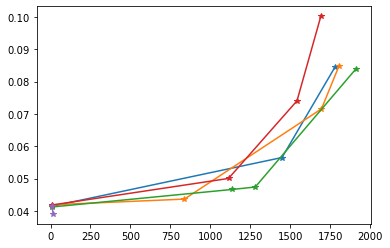

In [4]:
for cell in ir_dict:
    if ir_dict[cell]['IR'].shape[0] < 5:
        plt.plot(ir_dict[cell]['IR'][:,0], ir_dict[cell]['IR'][:,1], '*-')

### PCHIP interpolation

In [5]:
# Do the interpolation and store results in a dictionary
ir_interp = {cell: {'IR': None} for cell in ir_dict}

for cell in ir_dict.keys():
    x_observed = ir_dict[cell]['IR'][:,0]
    y_observed = ir_dict[cell]['IR'][:,1]
    # Get an array of integer cycle numbers from zero to the end
    x_cont = np.arange(1, x_observed[-1] + 1)
    y_interp = pchip_interpolate(x_observed, y_observed, x_cont)
    
    ir_interp[cell]['IR'] = np.vstack((x_cont, y_interp)).T
    
del x_observed, y_observed, x_cont, y_interp, cell

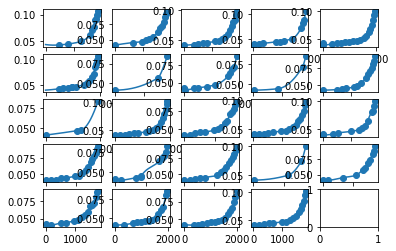

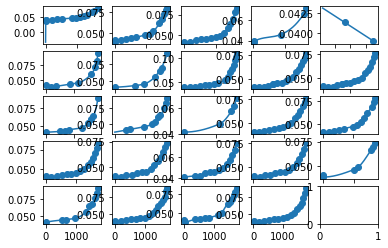

In [6]:
# Plot the results on 2 figures, because there are 48 cells

fig, ax = plt.subplots(5, 5)
for i, cell in enumerate(list(ir_dict.keys())[0:24]):
        
    ax.flatten()[i].scatter(ir_dict[cell]['IR'][:,0], ir_dict[cell]['IR'][:,1])
    ax.flatten()[i].plot(ir_interp[cell]['IR'][:,0], ir_interp[cell]['IR'][:,1])

plt.show()

fig, ax = plt.subplots(5, 5)
for i, cell in enumerate(list(ir_dict.keys())[24:]):
        
    ax.flatten()[i].scatter(ir_dict[cell]['IR'][:,0], ir_dict[cell]['IR'][:,1])
    ax.flatten()[i].plot(ir_interp[cell]['IR'][:,0], ir_interp[cell]['IR'][:,1])

plt.show()

### Run if Removing cell 030 before finding elbows

In [7]:
# del ir_interp['030']

### Fix dodgy values in 026 interpolated curve

In [7]:
ir_interp['026']['IR'][0:20, 1] = ir_interp['026']['IR'][20, 1]

### Generate Targets - Use KneeFinder

In [8]:
def get_knee_and_eol_results(parent_dict, params_dict, src='baumhofer', mode='knee', filter_data=False, truncate=False, normalise=False, to_plot=False):
    '''

    
    
    
    '''
    
    # Determine data_type from "mode" argument
    if mode == "knee":
        data_type = "capacity"
    elif mode == "elbow":
        data_type = "IR"
           

    # Create a DataFrame whose indices are cell names
    df = pd.DataFrame(columns=['onset', 'point', 'EOL', 'onset_y', 'point_y'], index=parent_dict.keys())
    
    if to_plot:
        # Make one plot for each curve. Have a square array of subplots
        num_plots = int(np.sqrt(len(parent_dict.keys()))) + 1
        fig, ax = plt.subplots(num_plots, num_plots)

    for i, cell in enumerate(list(parent_dict.keys())):
                
        # Get the capacity data from the dictionary
        arr = copy.deepcopy(parent_dict[cell][data_type])
               
        # Introduce more readable variable names
        cycles = arr[:,0]
        orig_values = arr[:,1]
        
        if normalise:
            values = orig_values / np.max(orig_values)
        else:
            values = orig_values
        
        # Filter the data if specified
        if filter_data:
            values = medfilt(values, 5)
                    
        # Create an instance of KneeFinder
        kf = KneeFinder(cycles, values, mode=mode, truncate=truncate)            
        
        # Call the KneeFinder methods to find onset, point and EOL
        kf.set_params_using_dict(params_dict, data_type=data_type, src=src)
        kf.find_onset_and_point()
        kf.find_eol()
        
        # Populate the DataFrame with the identified onset and point
        df.loc[cell]['onset'] = kf.onset
        df.loc[cell]['point'] = kf.point
        df.loc[cell]['EOL'] = kf.eol_cycle
        
        # Get the y values on the original scale, if normalise is True
        if normalise:
            df.loc[cell]['onset_y'] = kf.onset_y * np.max(orig_values)
            df.loc[cell]['point_y'] = kf.point_y * np.max(orig_values)
            # Multiply the fit values to recover original scale
            kf.exp_fit = kf.exp_fit * max(orig_values)
            if truncate:
                kf.sig_fit = kf.sig_fit * max(orig_values)
        else:
            df.loc[cell]['onset_y'] = kf.onset_y
            df.loc[cell]['point_y'] = kf.point_y

    
        if to_plot:
            ax.flatten()[i].plot(cycles, orig_values)

            ax.flatten()[i].axvline(kf.onset)
            ax.flatten()[i].axvline(kf.point)
            ax.flatten()[i].plot(kf.x_cont[kf.indices], kf.exp_fit)
            #if truncate:
                #ax.flatten()[i].plot(kf.x_cont, kf.sig_fit)        
            if kf.eol_reached:
                ax.flatten()[i].axvline(kf.eol_cycle, color='red')
            ax.flatten()[i].set_title(cell)

    if to_plot:
        plt.show()
    
    return df

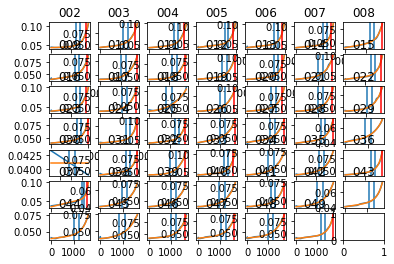

In [9]:
df_elbows = get_knee_and_eol_results(parent_dict=ir_interp,
                                     params_dict=params_dict,
                                     src='baumhofer',
                                     mode='elbow',
                                     filter_data=False,
                                     truncate=False,
                                     normalise=False,
                                     to_plot=True)

In [11]:
def create_y_IR_target_array(parent_dict, key, cell_ID, df, lo_idx, hi_idx):
    '''
    For a particular cell_ID in parent_dict, generate an array with 5 columns.
    
    These columns represent:
    - Number of cycles remaining until elbow onset
    - Number of cycles remaining until elbow point
    - IR increase until elbow onset
    - IR increase until elbow point
    
    
    Parameters
    ----------
    parent_dict (type: dict)
        Dictionary whose keys are cell IDs, containing 2D cycle/IR array in a key
        
    key (type: str)
        Dictionary key that is used to identify the cycle/IR 2D array.
        
    cell_ID (type: str)
        Cell identifier string used to specify the keys of parent_dict to extract cell data.
        
    df (type: pd.DataFrame)
        A DataFrame containing, for each cell, 4 values (cycle number for onset, cycle number for point, IR at onset and IR at point).
        This is obtained using the function "get_knee_and_eol_results"    
    
    lo_idx (type: int)
        Index in the capacity array that corresponds to the first cycle of time series data.
        This is needed if you have taken cycles 2 to 101 for each cell, for example.
    
    hi_idx (type: int)
        Index in the capacity array that corresponds to the last cycle of time series data.
        This is needed if you have taken cycles 2 to 101 for each cell, for example.
    
    
    '''
    
    
    # Extract the 2D array of cycles/interpolated capacity values from the dictionary
    ir_arr = parent_dict[cell_ID][key]
    ir_arr = ir_arr[lo_idx:hi_idx+1]

    # Create a DataFrame so we can explicitly refer to the column names for assignment
    result = pd.DataFrame(np.zeros(shape=(ir_arr.shape[0], 4), dtype=float),
                          index=ir_arr[:,0].astype(int),
                          columns=['tto', 'ttp', 'deg_o', 'deg_p'])

    # Populate the result DataFrame with values
    result['tto'] = df.at[cell_ID, "onset"] - ir_arr[:,0]
    result['ttp'] = df.at[cell_ID, "point"] - ir_arr[:,0]
    #result['tte'] = df.at[cell_ID, "EOL"] - ir_arr[:,0]
    result['deg_o'] = df.at[cell_ID, "onset_y"] - ir_arr[:,1]
    result['deg_p'] = df.at[cell_ID, "point_y"] - ir_arr[:,1]
    

    # Convert the DataFrame to a numpy array
    result_arr = result.to_numpy(copy=True)
    
    return result_arr

cell 30 is missing data so we replace it here with the cell 31. This will not be used in our analysis, just to get the right dimension.

In [38]:
ir_interp['030'] = ir_interp['031']

In [42]:
# Get the y array of IR targets (cycles until onset, point and EOL; IR rise until onset and point)
y_IR = np.vstack([create_y_IR_target_array(ir_interp,'IR', cell_ID, df_elbows, lo_idx=2, hi_idx=100) for cell_ID in ir_interp])
# Create an array that tells us which cell each instance belongs to
index_IR = np.hstack([[str(i).zfill(3)]*99 for i in range(2,50)])

assert(len(y_IR) == len(index_IR))

In [45]:
len(y_IR)

4752

In [46]:
# Save the arrays to file
with open("./data/y_IR_baumhofer_for_one_cycle.pkl", "wb") as a_file:
    pickle.dump(y_IR, a_file)
    
with open("./data/elbows_df_baumhofer_for_one_cycle.pkl", "wb") as a_file:
    pickle.dump(df_elbows, a_file)
    
with open("./data/index_IR_baumhofer_for_one_cycle.pkl", "wb") as a_file:
    pickle.dump(index_IR, a_file)
    
del a_file

## Experimental below here

### Try fitting the line plus exponential to the data prior to generating the y targets

In [16]:
# Pick a cell
cell = '009'
x = copy.deepcopy(ir_interp[cell]['IR'][:,0])
y = copy.deepcopy(ir_interp[cell]['IR'][:,1])

kf = KneeFinder(cycles=x, y=y, truncate=False, mode='elbow')
kf.set_params_using_dict(params_dict, data_type='IR', src='baumhofer')
kf.find_onset_and_point()
y_line_exp = kf.exp_fit

plt.plot(x, y, label='PCHIP interpolated')
plt.plot(x, y_line_exp, label='Line + exp applied to PCHIP interpolated curve')
plt.xlabel("Cycle number")
plt.ylabel("IR")
plt.legend()
plt.title(f"Cell {cell}")
plt.show()

In [17]:
# Apply the line plus exponential to every fit and save the results
# in a new dictionary to easily compare the resulting target arrays
ir_fix = copy.deepcopy(ir_interp)

for cell in ir_fix:
    x = ir_fix[cell]['IR'][:,0]
    y = ir_fix[cell]['IR'][:,1]

    kf = KneeFinder(cycles=x, y=y, truncate=False, mode='elbow')
    kf.set_params_using_dict(params_dict, data_type='IR', src='baumhofer')
    kf.find_onset_and_point()
    y_line_exp = kf.exp_fit
    
    # Replace the PCHIP interpolation with the line plus exponential fit to the PCHIP interpolation
    ir_fix[cell]['IR'][:,1] = y_line_exp

### Get the y array of 5 targets for each cycle
**Notice that I've removed the EOL, since not all cells die by IR 200% and we will use 80% capacity EOL anyway**

In [19]:
# Get a list of the cell IDs
cells = list(ir_interp.keys())

# Instantiate index values to be passed to create_y_target_array.
# These are the indices for the capacity arrays for which the cycle
# numbers match those whose time series data we are using.
lo_idx = 2
hi_idx = 100

# Create the y target array for all cells, for the first N cycles of each cell
# THIS USES THE PCHIP INTERPOLATION DATA DIRECTLY
y_arr_IR = np.vstack([create_y_IR_target_array(parent_dict=ir_interp, key='IR', cell_ID=cell, df=df_elbows, lo_idx=lo_idx, hi_idx=hi_idx) for cell in cells])

# THIS USES THE ATTEMPTED FIX
y_arr_IR_fix = np.vstack([create_y_IR_target_array(parent_dict=ir_fix, key='IR', cell_ID=cell, df=df_elbows, lo_idx=lo_idx, hi_idx=hi_idx) for cell in cells])

### Take a look at an individual cell, with onset and point annotated

In [20]:
cell = '009'

fig, ax = plt.subplots()
ax.plot(ir_fix[cell]['IR'][:,0], ir_fix[cell]['IR'][:,1])
ax.axvline(df_elbows.loc[cell, 'onset'])
ax.axvline(df_elbows.loc[cell, 'point'])

### Compare the PCHIP interpolation and PCHIP + line_exp fit

In [21]:
fig, ax = plt.subplots(2,1)

ax[0].plot(y_arr_IR[:,2], alpha=0.4, label='IR rise until onset (from PCHIP interpolation)')
ax[0].plot(y_arr_IR_fix[:,2], label='IR rise until onset (from line_exp fit applied to PCHIP interpolation)')
ax[0].legend()

ax[1].plot(y_arr_IR[:,3], alpha=0.4, label='IR rise until point (from PCHIP interpolation)')
ax[1].plot(y_arr_IR_fix[:,3], label='IR rise until point (from line_exp fit applied to PCHIP interpolation)')
ax[1].legend()

plt.show()